# Mongo_review p14.3 - 

# 14.3 - Using Statistical Tests
Shows some examples of using statistical tests to get qualitative results from questions asked of the accidents dataset.

In [1]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

In [2]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels

In [3]:
# load the expanded names of keys and human-readable codes into memory
expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {'$exists': True}}):
    expanded_name[e['label']] = e['expanded']

label_of = collections.defaultdict(str)
for l in labels.find({'codes': {'$exists': True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError:
            label_of[l['label'], c ] = l['codes'][c]


## Pearson's _R^2_
### Comparing the number of casualties and vehicles
This is the same investigation as in pt `14.2 - Introdution to accidents`

In [4]:
# Build a dataframe, one row for each accident
cas_veh_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Number_of_Casualties', 'Number_of_Vehicles'])))

# Count the number of each severity
cas_veh_df = pd.crosstab(cas_veh_unrolled_df['Number_of_Casualties'], 
                         cas_veh_unrolled_df['Number_of_Vehicles'])

# Reshape the dataframe
cas_veh_long_df = cas_veh_df.stack().reset_index()
cas_veh_long_df.head()

,Number_of_Casualties,Number_of_Vehicles,0
0,1,1,39217
1,1,2,65680
2,1,3,6168
3,1,4,1056
4,1,5,197


Let's plot it like earlier with the regression line

In [5]:
regressionline = scipy.stats.linregress(cas_veh_unrolled_df['Number_of_Casualties'], 
                                        cas_veh_unrolled_df['Number_of_Vehicles'])

# the regression line is of the form y = m * x + b
m = regressionline[0]
b = regressionline[1]
(m,b)

(0.21101011188488833, 1.5427349394560317)

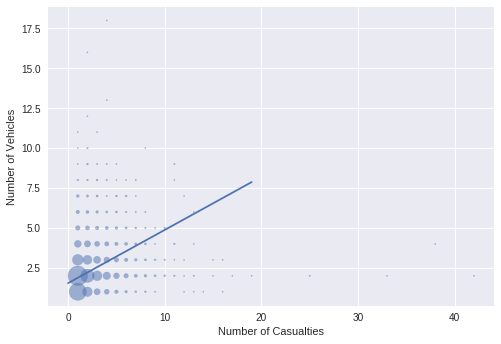

In [6]:
# Make the scatter plot
import seaborn as sb

plt.scatter(cas_veh_long_df['Number_of_Casualties'], 
            cas_veh_long_df['Number_of_Vehicles'], 
            s=np.sqrt(cas_veh_long_df[0])*1.5, 
            alpha=0.5
           )

x = np.linspace(0, 30, 20)
plt.plot(m*x+b)

plt.xlabel('Number of Casualties')
plt.ylabel('Number of Vehicles')

In [7]:
sb.set_style('white')
sb.set_palette('dark')

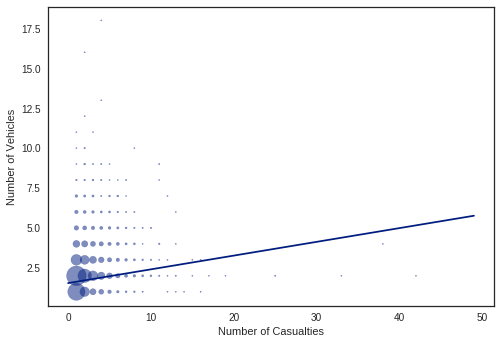

In [17]:
plt.scatter(cas_veh_long_df['Number_of_Casualties'], 
            cas_veh_long_df['Number_of_Vehicles'], 
            s=np.sqrt(cas_veh_long_df[0])*1.5, 
            alpha=0.5
           )

x = np.linspace(0, 20, 50)
plt.plot(m*x+b)

plt.xlabel('Number of Casualties')
plt.ylabel('Number of Vehicles')

The `pearsonr` function calculates Pearson's *R*² value of correlation. The function takes two lists of numbers, of equal lengths. The pearson's *R*² function looks at the values at the same index in both lists and finds how the values in one column vary with respect to the other column.

Note that we have to give each accident on it's own row: if there are 145,000 accidents, the `pearsonr` function must be passed lists with 145,000 items.

Recall that values near +1 show good positive correlation, values near -1 show good negative correlation, and values near 0 show no particular correlation. The `scipy` function rturns a second value, the *p* value of the result.

In [19]:
scipy.stats.pearsonr(cas_veh_unrolled_df['Number_of_Casualties'], 
                     cas_veh_unrolled_df['Number_of_Vehicles'])

(0.2415849093923253, 0.0)

This result shows a small, positive correlation with avewy small _p_ value. In other words, there's not much correlation, and the result is statistically significant.  this means we can reject the null hypothesis that the number of casualties in an accident is unrelated to the number of vehicles.

Looking at the data, it seems that to be a result that most accidents result in very few casualties, and the accidents with the most casualties have few vehicles.

Can you think of a reason for this?


_Coach / bus accidents could result in many casualties despite having few vehicles involved._

### Activity 1
Ages of people in the accidents dataset are stored as bands, not continuous values. This means that correlations between them must use Spearman's *r*.

Calculate the Spearman rank-order correlation coefficient between the age of a vehicle's driver and the age of the passengers. 

Similar to the Pearson function above, the `scipy.stats.spearmanr()` function takes two parameters, each a list of values for the two variables being compared. 

You'll need to create an `unrolled` DataFrame with one row for each injured passenger. Each row should have two values: one for the age band of the driver, and one for the age band of a passenger. If the vehicle has multiple passengers, the DataFrame should have one row for each passenger. (Each element of `Casualties` has a `Vehicle_Reference` that relates it to the vehicle the casualty was in.)

We're interested in the relationship between drivers and passengers, so don't include the driver as a casualty. (Use the `Casualty_Class` to find out.)

Don't include any driver-passenger pairs where the age of one of them is unknown (code -1).

**Hint**

Each accident document contains a list of vehicles and a list of casualties. For each accident, you'll need to iterate through both of these to find the information for each individual casualty.

The solution is in the [`14.3solutions`](14.3solutions.ipynb) Notebook.

In [27]:
accidents.find_one()

{'1st_Road_Class': 3,
 '1st_Road_Number': 308,
 '2nd_Road_Class': 5,
 '2nd_Road_Number': 0,
 'Accident_Index': '201201BS70001',
 'Accident_Severity': 3,
 'Carriageway_Hazards': 0,
 'Casualties': [{'Age_Band_of_Casualty': 7,
   'Bus_or_Coach_Passenger': 0,
   'Car_Passenger': 0,
   'Casualty_Class': 1,
   'Casualty_Home_Area_Type': 1,
   'Casualty_Reference': 1,
   'Casualty_Severity': 3,
   'Casualty_Type': 1,
   'Pedestrian_Location': 0,
   'Pedestrian_Movement': 0,
   'Pedestrian_Road_Maintenance_Worker': 0,
   'Sex_of_Casualty': 1,
   'Vehicle_Reference': 2}],
 'Date': '19/01/2012',
 'Datetime': datetime.datetime(2012, 1, 19, 20, 35),
 'Day_of_Week': 5,
 'Did_Police_Officer_Attend_Scene_of_Accident': 1,
 'Junction_Control': 2,
 'Junction_Detail': 6,
 'LSOA_of_Accident_Location': 'E01002821',
 'Latitude': 51.493429,
 'Light_Conditions': 4,
 'Local_Authority_(District)': 12,
 'Local_Authority_(Highway)': 'E09000020',
 'Location_Easting_OSGR': 527200,
 'Location_Northing_OSGR': 178760,

In [26]:
# monstrous list comprehension

# get the vehicle age of driver, and the casualty age
# for each accident's cashualties, and vehicles
driver_passenger_unrolled_df = pd.DataFrame([
    {'Age_Band_of_Driver': v['Age_Band_of_Driver'],
    'Age_Band_of_Casualty': c['Age_Band_of_Casualty']}
    for a in accidents.find({})
    for c in a['Casualties']
    for v in a ['Vehicles']
    if c['Vehicle_Reference'] == v['Vehicle_Reference']
    if c['Casualty_Class'] == 2
    if c['Age_Band_of_Casualty'] != -1
    if v['Age_Band_of_Driver'] != -1
])

driver_passenger_unrolled_df.head()

,Age_Band_of_Casualty,Age_Band_of_Driver
0,5,5
1,11,5
2,4,4
3,4,4
4,4,4


In [22]:
# reshape to plot
# crosstab to get the counts
driver_passenger_df = pd.crosstab(driver_passenger_unrolled_df['Age_Band_of_Driver'], 
                                  driver_passenger_unrolled_df['Age_Band_of_Casualty'])
# stack so we can plot a scatter
driver_passenger_long_df = driver_passenger_df.stack().reset_index()



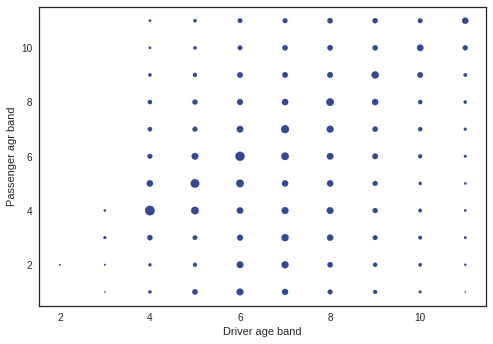

In [23]:
plt.scatter(driver_passenger_long_df['Age_Band_of_Driver'],
            driver_passenger_long_df['Age_Band_of_Casualty'], 
            s=np.sqrt(driver_passenger_long_df[0])*1.5, 
            alpha=0.8)

plt.xlabel('Driver age band')
plt.ylabel('Passenger agr band')

plt.show()

We can now apply the Spearmenr function to calculate the rho value

In [24]:
scipy.stats.spearmanr(driver_passenger_unrolled_df['Age_Band_of_Driver'], 
                      driver_passenger_unrolled_df['Age_Band_of_Casualty'])

SpearmanrResult(correlation=0.40612591615498272, pvalue=0.0)

This shows a reasonable positive correlation.  The older the driver is the older the passenger tends to be.

the _p_ value of 0.0 means that this correlation could not have happened by chance.

## Chi-Squared example 1: hypothetical voting intention


In [28]:
actual_survey_results = pd.DataFrame({'Conservative': {'Men': 170, 'Women': 220},
                                      'Labour': {'Men': 240, 'Women':190}, 
                                      'Other': {'Men': 80, 'Women': 100}})
actual_survey_results

,Conservative,Labour,Other
Men,170,240,80
Women,220,190,100


We could find the expected counts manually, or we could use the `scipi.stats.contingency.expected_freq()` function to do it for us.  Note that this returns an array, rather than a DataFrame, but it's the samie shape as the original.

In [30]:
scipy.stats.contingency.expected_freq(actual_survey_results)

array([[ 191.1,  210.7,   88.2],
       [ 198.9,  219.3,   91.8]])

In [35]:
# manually calculate the expeched counts
def expected_of_df(actual_df):
    df = pd.DataFrame(
        {col:
         {row: actual_df[col].sum() * actual_df.loc[row].sum() / actual_df.sum().sum() for row in actual_df[col].index}
         for col in actual_df})
    # fix the order of the columns
    df = df[actual_df.columns]
    df = df.reindex(actual_df.index)
    return df

In [36]:
expected_survey_results = expected_of_df(actual_survey_results)
expected_survey_results

,Conservative,Labour,Other
Men,191.1,210.7,88.2
Women,198.9,219.3,91.8


As we're using a table of several rows and columns, we use the `scipy.stats.chi2_contingency()` function to find the $\chi ^ 2$ statistic ant the _p_ value.

Note that the function returns $\chi ^ 2$, the _p_ value, the number of degrees of freedom, and the matrix of expected frequencies.  Fe're generally after just the second returned value, the _p_ value.

In [37]:
scipy.stats.chi2_contingency(actual_survey_results)


(14.05205294202754, 0.00088845507800327844, 2, array([[ 191.1,  210.7,   88.2],
        [ 198.9,  219.3,   91.8]]))

In [38]:
# assign the results we want to variables
chi2, p, _, _ = scipy.stats.chi2_contingency(actual_survey_results)

chi2, p

(14.05205294202754, 0.00088845507800327844)

The _p_ value of 0.0009 means that we can reject the null hypothesis that voting intention is independent of gender: for this example, it seems that we can say that men and women vote differently.

Adjusting the numbers we can get a very different result/


In [39]:
actual_survey_results_2 = pd.DataFrame({'Conservatives': {'Men': 170, 'Women': 220}, 
                                        'Labour': {'Men': 220, 'Women': 210}, 
                                        'Other': {'Men': 80, 'Women': 100}})
actual_survey_results_2

,Conservatives,Labour,Other
Men,170,220,80
Women,220,210,100


In [40]:
expected_survey_results_2 = expected_of_df(actual_survey_results_2)
expected_survey_results_2

,Conservatives,Labour,Other
Men,183.3,202.1,84.6
Women,206.7,227.9,95.4


In [41]:
chi2, p, _, _ = scipy.stats.chi2_contingency(actual_survey_results_2)
chi2, p

(5.2840593858024087, 0.071216574986591411)

In this case the _p_ value of 0.07 means we __cannot__ reject the null hypothesis that voting intention is independent of gender: therfore for this modified example, we can't say that men and women vote differently

## Chi Square example 2: accident frequency by day of week
Let's look to see if more accidents occur on different days of the week.

In [42]:
# Build a DataFrame, one row for each accident
count_by_day_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Day_of_Week'])))

# Find counts for each day
count_by_day_ss = count_by_day_unrolled_df['Day_of_Week'].value_counts()

# Reorder by day of week, add labels.
count_by_day_ss.sort_index(inplace=True)
count_by_day_ss.index = [label_of['Day_of_Week', r] for r in count_by_day_ss.index]

count_by_day_ss

Sunday       15856
Monday       20910
Tuesday      21661
Wednesday    21997
Thursday     22334
Friday       23511
Saturday     19302
Name: Day_of_Week, dtype: int64

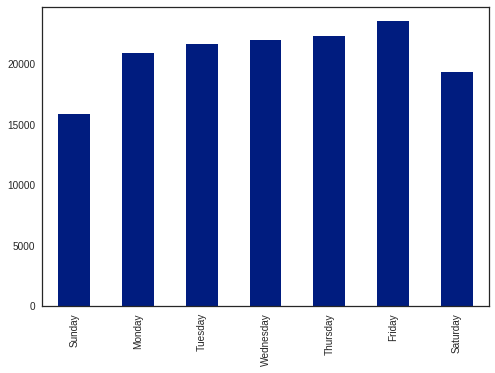

In [43]:
count_by_day_ss.plot(kind='bar')

Because the contingency chi2 function expects at least two rows and columns they don't work on series.  So we must use less convenient functions.

Step 1 - find the expected values

In [44]:
expected_count_by_day_ss = pd.Series(count_by_day_ss.sum() / len(count_by_day_ss),
                                     index=count_by_day_ss.index)
expected_count_by_day_ss

Sunday       20795.857143
Monday       20795.857143
Tuesday      20795.857143
Wednesday    20795.857143
Thursday     20795.857143
Friday       20795.857143
Saturday     20795.857143
dtype: float64

Step 2 - use the scipy.stats.chisquare() function

In [45]:
scipy.stats.chisquare(count_by_day_ss, expected_count_by_day_ss)

Power_divergenceResult(statistic=1854.9813355682106, pvalue=0.0)

a _p_ value of 0,0 is a significant result and shows that the varyiug number of accidents by day is significant.

## P14.4 - Regression on subgroups
Looking at some factors that affect the connection between the number of casualties and vehicles in an accident.  By splitting the accidents dataset into 2 groups and comparing them.

In [89]:
# Import the required libraries
import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

In [90]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels

In [91]:
# Load the expanded names of keys and human-readable codes into memory

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

## Pearson's _R^2_
Let's look at the whole set aqain

In [92]:
# Build a dataframe, one row for each accident
cas_veh_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Number_of_Casualties', 'Number_of_Vehicles'])))

# count the number of each
cas_veh_df = pd.crosstab(cas_veh_unrolled_df['Number_of_Casualties'], 
                         cas_veh_unrolled_df['Number_of_Vehicles'])

# reshape
cas_veh_long_df = cas_veh_df.stack().reset_index()
cas_veh_long_df

,Number_of_Casualties,Number_of_Vehicles,0
0,1,1,39217
1,1,2,65680
2,1,3,6168
3,1,4,1056
4,1,5,197
5,1,6,76
6,1,7,27
7,1,8,4
8,1,9,1
9,1,10,1


In [94]:
regressionline = scipy.stats.linregress(cas_veh_unrolled_df['Number_of_Casualties'], 
                                        cas_veh_unrolled_df['Number_of_Vehicles'])

# the regression line is of the form y=m x + b
m, b = regressionline[0], regressionline[1]
m, b


(0.21101011188488833, 1.5427349394560317)

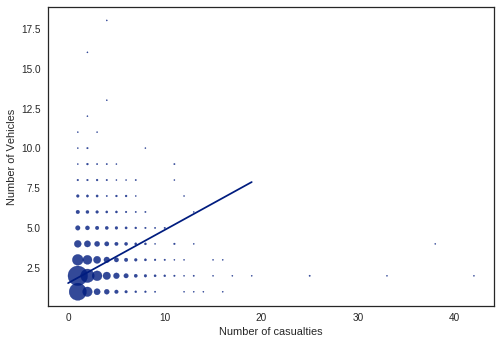

In [95]:
# plot
plt.scatter(cas_veh_long_df['Number_of_Casualties'],
            cas_veh_long_df['Number_of_Vehicles'], 
            s=np.sqrt(cas_veh_long_df[0])*1.5, 
            alpha=0.8
           )

x = np.linspace(0,30, 20)
plt.plot(x*m+b)

plt.xlabel('Number of casualties')
plt.ylabel('Number of Vehicles')
plt.show()


The `pearsonr` function calculates Pearson's *R*² value of correlation. Recall that values near +1 show good positive correlation, values near -1 show good negative correlation, and values near 0 show no particular correlation. The `scipy` function returns a second value, the *p* value of the result. 

In [97]:
scipy.stats.pearsonr(cas_veh_unrolled_df['Number_of_Casualties'], 
                     cas_veh_unrolled_df['Number_of_Vehicles'])

(0.2415849093923253, 0.0)

This result shows a small, positive correlation with a very small _p_ value.  In other words there is not much correlation and the result is statistically significant.  This means we can reject the null hypothesis that the number of casualties in an accident is unrelated ti the number of vehicles. 

Looking at the data, it seems to be a result that most accidents result in very few casualties and the accidents with the most casualties have few vehicles.

### Activity 1
Investigate the types of vehicles that are involved in the largest accidents (i.e. those accidents with more than 8 casualties). What types of vehicles appear in the multiple-casualty accidents?

For each accident with more than 8 casualties, list the vehicles involved. For each vehicle, print the type of vehicle and the number of casualties in it, in a format similar to this:

```
Acc index 201201GD10531; 9 casualties, 3 vehicles
	Car: 1 casualties
	Car: 5 casualties
	Bus: 3 casualties
Acc index 201201KF60687; 11 casualties, 3 vehicles
	Taxi/Private: 2 casualties
	Taxi/Private: 4 casualties
	Taxi/Private: 5 casualties
```

**Hint**

Because you'll want to look at the vehicles involved in each accident, it's easier to keep the data in standard Python data structures, unchanged from the result of a pymongo `find()`.

The solution is in the [`14.4solutions`](14.4solutions.ipynb) Notebook.

In [105]:
accidents.find_one({'Number_of_Casualties':{'$gt': 8}})

{'1st_Road_Class': 3,
 '1st_Road_Number': 105,
 '2nd_Road_Class': 6,
 '2nd_Road_Number': 0,
 'Accident_Index': '201201GD10531',
 'Accident_Severity': 3,
 'Carriageway_Hazards': 0,
 'Casualties': [{'Age_Band_of_Casualty': 6,
   'Bus_or_Coach_Passenger': 0,
   'Car_Passenger': 1,
   'Casualty_Class': 2,
   'Casualty_Home_Area_Type': -1,
   'Casualty_Reference': 3,
   'Casualty_Severity': 3,
   'Casualty_Type': 9,
   'Pedestrian_Location': 0,
   'Pedestrian_Movement': 0,
   'Pedestrian_Road_Maintenance_Worker': 0,
   'Sex_of_Casualty': 1,
   'Vehicle_Reference': 1},
  {'Age_Band_of_Casualty': 7,
   'Bus_or_Coach_Passenger': 0,
   'Car_Passenger': 0,
   'Casualty_Class': 1,
   'Casualty_Home_Area_Type': 1,
   'Casualty_Reference': 1,
   'Casualty_Severity': 3,
   'Casualty_Type': 9,
   'Pedestrian_Location': 0,
   'Pedestrian_Movement': 0,
   'Pedestrian_Road_Maintenance_Worker': 0,
   'Sex_of_Casualty': 1,
   'Vehicle_Reference': 2},
  {'Age_Band_of_Casualty': 5,
   'Bus_or_Coach_Passenge

In [106]:
big_accidents = [a for a in accidents.find({'Number_of_Casualties': {'$gt': 8}},
                                           ['Accident_Index', 'Number_of_Casualties', 
                                            'Number_of_Vehicles', 'Casualties.Vehicle_Reference',
                                            'Vehicles.Vehicle_Reference', 'Vehicles.Vehicle_Type'])]
len(big_accidents)

66

In [103]:
# big_accidents[0]

In [113]:
for a in big_accidents:
    print('Acc index {0}; {1} casualties, {2} vehicles'.format(
        a['Accident_Index'],a['Number_of_Casualties'], a['Number_of_Vehicles'])
         )
    
    for v in a['Vehicles']:
        print('\t{0}: {1} casualties'.format(label_of['Vehicle_Type', v['Vehicle_Type']].split()[0], 
                                  len([c for c in a['Casualties'] 
                                       if c['Vehicle_Reference'] == v['Vehicle_Reference']])))

Acc index 201201GD10531; 9 casualties, 3 vehicles
	Car: 1 casualties
	Car: 5 casualties
	Bus: 3 casualties
Acc index 201201KF60687; 11 casualties, 3 vehicles
	Taxi/Private: 2 casualties
	Taxi/Private: 4 casualties
	Taxi/Private: 5 casualties
Acc index 201201WW50958; 10 casualties, 3 vehicles
	Car: 4 casualties
	Taxi/Private: 3 casualties
	Car: 3 casualties
Acc index 201204EA12275; 9 casualties, 2 vehicles
	Car: 0 casualties
	Minibus: 9 casualties
Acc index 201205EE01017; 9 casualties, 2 vehicles
	Car: 4 casualties
	Bus: 5 casualties
Acc index 201205EE03703; 12 casualties, 1 vehicles
	Bus: 12 casualties
Acc index 201205EE06006; 9 casualties, 3 vehicles
	Car: 3 casualties
	Car: 4 casualties
	Car: 2 casualties
Acc index 201205FF02477; 9 casualties, 2 vehicles
	Car: 0 casualties
	Car: 9 casualties
Acc index 201205FF05784; 9 casualties, 2 vehicles
	Minibus: 7 casualties
	Car: 2 casualties
Acc index 201205FF06439; 9 casualties, 2 vehicles
	Motorcycle: 1 casualties
	Other: 8 casualties
Acc in

### Activity 2
Separate out the types of accidents into those involving bus-like vehicles and those that don't, and calculate the regression scores for the subgroups.

The solution is in the [`14.4solutions`](14.4solutions.ipynb) Notebook.

In [115]:
# what are the vehicle types?
[(code, label_of[(key, code)]) for key, code in label_of if key == 'Vehicle_Type']

[(22, 'Mobility scooter'),
 (2, 'Motorcycle 50cc and under'),
 (109, 'Car (including private hire cars)'),
 (4, 'Motorcycle over 125cc and up to 500cc'),
 (106, 'Motorcycle over 125cc'),
 (20, 'Goods over 3.5t. and under 7.5t'),
 (90, 'Other vehicle'),
 (97, 'Motorcycle - unknown cc'),
 (11, 'Bus or coach (17 or more pass seats)'),
 (104, 'Motorcycle'),
 (18, 'Tram'),
 (9, 'Car'),
 (16, 'Ridden horse'),
 (113, 'Goods vehicle over 3.5 tonnes'),
 (5, 'Motorcycle over 500cc'),
 (98, 'Goods vehicle - unknown weight'),
 (23, 'Electric motorcycle'),
 (-1, 'Data missing or out of range'),
 (3, 'Motorcycle 125cc and under'),
 (10, 'Minibus (8 - 16 passenger seats)'),
 (21, 'Goods 7.5 tonnes mgw and over'),
 (108, 'Taxi (excluding private hire cars)'),
 (17, 'Agricultural vehicle'),
 (103, 'Motorcycle - Scooter'),
 (1, 'Pedal cycle'),
 (105, 'Motorcycle - Combination'),
 (110, 'Minibus/Motor caravan'),
 (8, 'Taxi/Private hire car'),
 (19, 'Van / Goods 3.5 tonnes mgw or under')]

In [116]:
# build a dataframe, one row for each accident
coach_unrolled_df = pd.DataFrame(list(accidents.find({'Vehicles.Vehicle_Type': {'$in': [10, 11]}},
                                                     ['Number_of_Casualties', 'Number_of_Vehicles'])))
len(coach_unrolled_df)

6941

In [117]:
# check we've got them all...
non_coach_unrolled_df = pd.DataFrame(list(accidents.find({'Vehicles.Vehicle_Type': {'$not': {'$in':[10, 11]}}}, 
                                                         ['Number_of_Casualties', 'Number_of_Vehicles'])))
len(non_coach_unrolled_df)

138630

In [118]:
len(coach_unrolled_df) + len(non_coach_unrolled_df) == accidents.find().count()

True

#### Find the regression for non-coach accidents

In [119]:
# Count the number
coach_df = pd.crosstab(coach_unrolled_df['Number_of_Casualties'], 
                       coach_unrolled_df['Number_of_Vehicles'])
coach_df

Number_of_Vehicles,1,2,3,4,5,6,7,11
Number_of_Casualties,,,,,,,,
1,2949,2228,234,32,4,3,1,1
2,204,530,98,15,6,2,0,0
3,51,205,36,13,3,1,1,1
4,22,86,16,9,0,1,0,0
5,7,54,5,0,1,0,1,0
6,6,31,4,2,1,0,0,0
7,3,17,0,2,0,0,0,0
8,4,9,3,1,0,0,0,0
9,1,7,2,0,0,0,0,0


In [122]:
# find the regression line
coach_regression_line = scipy.stats.linregress(coach_unrolled_df['Number_of_Casualties'], 
                                              coach_unrolled_df['Number_of_Vehicles'])

coach_m, coach_b = coach_regression_line[0], coach_regression_line[1]
coach_m, coach_b

(0.094595873483424742, 1.4894575649255768)

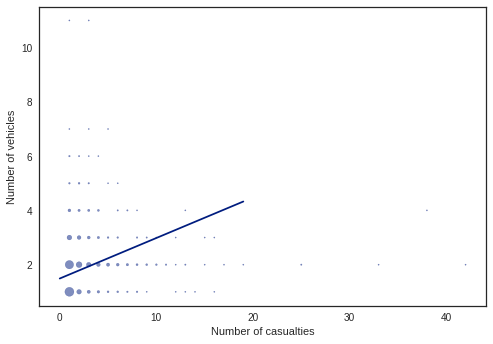

In [123]:
# Reshape and plot
coach_long_df = coach_df.stack().reset_index()

plt.scatter(coach_long_df['Number_of_Casualties'],
            coach_long_df['Number_of_Vehicles'],
            s=np.sqrt(coach_long_df[0])*1.5,
            alpha=0.5)

x = np.linspace(0, 30, 20)

plt.plot(coach_m*x+coach_b)

plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

In [124]:
scipy.stats.pearsonr(coach_unrolled_df['Number_of_Casualties'],
                     coach_unrolled_df['Number_of_Vehicles'])

(0.19583731511182584, 5.7796300309005693e-61)